Epoch 1/20
10/10 [==============================] - 1s 38ms/step - loss: 2705.1809 - constraint_learning: 2704.5327
Epoch 2/20
10/10 [==============================] - 0s 40ms/step - loss: 135.5761 - constraint_learning: 135.1000
Epoch 3/20
10/10 [==============================] - 0s 42ms/step - loss: 483.6259 - constraint_learning: 483.2875
Epoch 4/20
10/10 [==============================] - 0s 43ms/step - loss: 1353.4856 - constraint_learning: 1353.2500
Epoch 5/20
10/10 [==============================] - 0s 40ms/step - loss: 1659.9961 - constraint_learning: 1659.7750
Epoch 6/20
10/10 [==============================] - 0s 40ms/step - loss: 3173.5845 - constraint_learning: 3173.3999
Epoch 7/20
10/10 [==============================] - 0s 36ms/step - loss: 5058.7847 - constraint_learning: 5058.6250
Epoch 8/20
10/10 [==============================] - 0s 41ms/step - loss: 6233.9585 - constraint_learning: 6233.8252
Epoch 9/20
10/10 [==============================] - 0s 39ms/step - loss: 843

<IPython.core.display.Javascript object>


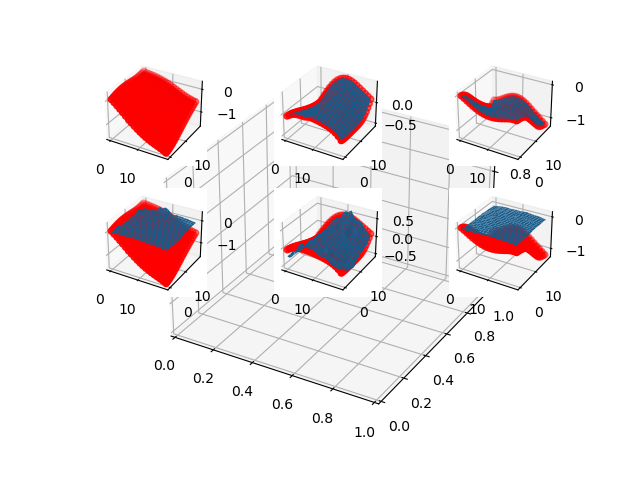

In [4]:
"""
    NN_RepresentativePoints_V5:
    
    This is the fifth attempt to "intelligently" decrease the resolution of images in a way that allows the original image
    to be reconstructed with minimal error. This is the second operational example. This version is very similar to V4 except
    that Identifier is being trained to develop a mask over the input data points as opposed to ranking the points by 
    importance with the top-k implementation of V4. 
    
    By developing a mask and multiplying it to the input data, a similar result to V4 can be achieved, but the whole process
    is differentiable, which should assist backpropogation and allows the @tf.function wrapper to be used to increase speed
    (ie, run_eagerly can equal false, leading to performance gains). However, this method could simply allow the model to
    learn to select all the datapoints, so to combat this we need to implement a loss function which minimises the number
    of nodes that activate in the mask (indicating point selection). This can simply be achieved by adding the sum of the
    difference in the number of activation and the desired bottleneck (selected points)as a loss, so the model will try to 
    minimise this. However, this becomes a more fluid property, and it will have to weigh this against other losses, and is
    hence not an enforceable constraint. This may be desirable in some cases where the model is able to dynamically select
    a suitable number of points to minimise the loss (e.g, hilly terrain will need more points than a flat field).
    
    
    This model still has spatial problems, where the network has to learn how nodes are related spatially which is a challenge
    for a network to learn reliably. As a result, the outputs tend to be spikey. The custom loss constraint also poses issues
    where it is easier to reduce the loss associated with the number of representative points (by selecting zero) than it is
    to reduce the mean squared error compared to the landscape. 
    
    The model is still represented by: 
                                
    Identifier(data, bottlenecks):ranking 
                                        -> Selector(ranking, bottlenecks, data):representatives 
                                                                    -> Interpolator(representatives):reconstruction
    
    Pros:
        "Simple" implementation (quite modular)
        Easily adjustable
        Fast
        Generator allows training on synthesised data where real data is lacking
        Visualisation
        Spatially aware initialisation (removes symmetry in architecture)
        Differentiable Selector layer, which supposedly will assist backpropogation and allows @tf.function for speed-up
        Can weigh off the number of points selected against the reconstruction error (though need to tune hyperparameters here)
    Cons:
        poor performance
        quite volatile (varying performance, need to be quite concerned with hyperparameters, especially with random bottleneck)
        dropouts not included
        dense networks don't encode spatial information (result is spikey and takes time to learn (locally overfitting))
        Not able to reliably "compress" over compressions (fixed format)
        selection tends to be the highest values in the image, indicating the selector is performing poorly
        results are clustered together, indicating that the top-k model selects areas of interest rather than individual points
        No explicit connection between data points and the mask
    """
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PerlinNoiseReduced as pn
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib notebook

class Selector(keras.layers.Layer):
    """
    This is the layer responsible for selecting "bottleneck" data points representing the most informative points
    
    Params:
        inputs(num_batches, image_size):          The ranking produced by Identifier
        bottleneck(num_batches, image_size):      The number of points to be selected
        data(num_batches, image_size):            The data points to select
    Outputs:
        representatives(num_batches, image_size): The points selected to represent the image
    """
    def build(self, input_shape):
        self.layer = keras.layers.Dense(units = input_shape[2][1], activation = tf.nn.sigmoid, kernel_initializer = "identity")
    
    def call(self, inputs):
        inputs, bottleneck, data = inputs
        # calculate the mask
        activation = self.layer(inputs)
        # apply the mask
        output = tf.multiply(activation, data)
        # minimise the difference between the bottleneck and the number of nodes activated
        loss = tf.reduce_mean(tf.square(tf.reduce_sum(activation, axis = -1)-tf.cast(bottleneck, tf.float32)))
        self.add_loss(loss)
        self.add_metric(loss, name = "constraint_learning")
        return output
        
class Identifier(keras.layers.Layer):
    """
    This is the layer responsible for ranking which points are best for interpolation.
    
    Init:
        layer_units(list(int)):                   The size of each Dense layer
    Params:
        data(num_batches, image_size):            The data points to rank
        bottleneck(num_batches, image_size):      The number of points to be selected
    Outputs:
        representatives(num_batches, image_size): The points selected to represent the image
    """
    def __init__(self, layer_units):
        super(Identifier, self).__init__()
        self.layers = []
        for unit in layer_units:
            self.layers.append(keras.layers.Dense(units = unit, activation = tf.nn.relu, kernel_initializer = "identity"))
        self.selector = Selector()
            
    def call(self, inputs):
        data, bottleneck = inputs
        # give the model the bottleneck value to self learn bottleneck constraint
        activation = tf.concat([data, tf.cast(bottleneck[:,tf.newaxis], tf.float32)], axis = 1)
        for layer in self.layers:
            activation = layer(activation)
        return self.selector((activation, bottleneck, data))
    
class Interpolator(keras.layers.Layer):
    """
    This is the layer responsible for trying to interpolate between the representative points to reconstruct the image
    
    Init:
        layer_units(list(int)):                   The size of each Dense layer
    Params:
        inputs(num_batches, image_size):          The representative points
    Outputs:
        activation(num_batches, image_size):      The reconstructed image
    """
    def __init__(self, layer_units):
        super(Interpolator, self).__init__()
        self.layers = []
        for unit in layer_units:
            self.layers.append(keras.layers.Dense(units = unit, activation = tf.nn.relu, kernel_initializer = "identity"))
        
    def build(self, original_shape):
        self.final = keras.layers.Dense(units = original_shape[1], kernel_initializer = "identity")
            
    def call(self, inputs):
        for layer in self.layers:
            inputs = layer(inputs)
        inputs = self.final(inputs)
        return inputs
    
class RepresentativePoints(tf.keras.Model):
    """
    This is the Model combining the Identifier, Selector and Interpolator Layers.
    
    Init:
        identifier_units:                         The units for each layer in the identifier
        interpolator_units:                       The units for each layer in the interpolator
    Params:
        inputs(num_batches, image_size):          The image
    Outputs:
        interpolation(num_batches, image_size):   The reconstructed image
    """
    def __init__(self, identifier_units, interpolator_units):
        super(RepresentativePoints, self).__init__()
        self.identifier = Identifier(identifier_units)
        self.interpolator = Interpolator(identifier_units)
    
    def call(self, inputs, training = None):
        inputs = self.identifier(inputs)
        interpolation = self.interpolator(inputs)
        return interpolation if training else (inputs, interpolation)
        
class Generator(tf.keras.utils.Sequence):
    """
    A generator for data. This one generates it from the perlin noise generator and implements the epoch dependent 
    bottleneck generation to achieve the effect of the model starting with a large bottleneck so that the interpolator
    can learn how to recreate the image from all the points in the image. Gradually, the bottleneck value is decreased
    which results in the interpolator and identifier collectively learning how to reconstruct the image with fewer pixels
    (and accordingly select the most informative data points, after all, the identifier selects informative points based
    on how well the interpolator can use them to reconstrcut the image). This is done by randomly selecting a bottleneck
    value between the maximum number of pixels and some lower bound as a function of the current epoch.
    
    Init:
        image_shape:                              The shape of the output image
        max_epochs:                               The max number of epochs
        steps_per_epoch:                          How many training steps occur each epoch
        epoch_func:                               The lower bound on bottleneck as a function of the current epoch
        batch_size:                               The number of samples in a batch, defalulting to 32
    Outputs:
        ((images, bottlenecks),images):           A pair of training, testing results, where the training ones
                                                    are the input image and the desired number of representative 
                                                    points (bottleneck) and the testing one is the image to be 
                                                    used with mean squared error on the reconstructed image
    """
    def __init__(self, image_shape, max_epochs, steps_per_epoch, epoch_func = None, batch_size = 32):
        self.data_size = image_shape.prod()
        self.noise = pn.PerlinNoise(image_shape)
        self.current_epoch = 0
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        # default is a linear function, it starts with the maximum points and decreases linearly until the last epoch
        def linear(epoch):
            return 1-epoch/max_epochs
        self.epoch_func = linear if epoch_func is None else epoch_func
        self.batch_size = batch_size
        
    def __len__(self):
        return self.max_epochs*self.steps_per_epoch
    
    def __getitem__(self, step):
        images = np.zeros((self.batch_size, self.data_size))
        # this is some safety so that the number of pixels selected is some subset of what is in the image
        low = max(1, min(self.data_size, int(self.data_size*self.epoch_func(self.current_epoch))))
        # bottlenecks are determined randomly between the lower bound and maximum points
        bottlenecks = np.random.randint(low = low, high = self.data_size+1, size = self.batch_size)
        for b in range(self.batch_size):
            images[b] = self.noise.generate_fractal().flatten().flatten()
            # normalising for performance in neural network
            images[b] = images[b]/np.max(images[b])
            # as generate_fractal operates iteratively on a class variable, this resets it
            self.noise.reset()
        return ((images, bottlenecks),images)
    
    def on_epoch_end(self):
        self.current_epoch +=1

"""
    These are hyperparameters which are positioned together here for ease of change
    
    Variables:
        dim:                The dimension of the image
        BATCH_SIZE:         How many images are trained in parallel
        EPOCHS:             How many batches of images are used to train (~training steps)
        IDENTIFIER_UNITS:   The units for each layer in the identifier
        INTERPOLATOR_UNITS: The units for each layer in the interpolator
"""
        
dim = 20
image_shape = np.array((dim,dim))

BATCH_SIZE = 8
EPOCHS = 20
STEPS_PER_EPOCH = 10
IDENTIFIER_UNITS = [image_shape.prod(), image_shape.prod(), image_shape.prod(), image_shape.prod(), image_shape.prod()]
INTERPOLATOR_UNITS = [image_shape.prod(), image_shape.prod(), image_shape.prod(), image_shape.prod(), image_shape.prod()]

# initialising the model
model = RepresentativePoints(identifier_units = IDENTIFIER_UNITS, interpolator_units = INTERPOLATOR_UNITS)
model.compile(optimizer = "Adam", loss = "mse", run_eagerly = True)

# fitting the data
data = Generator(image_shape, max_epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, batch_size = BATCH_SIZE)

model.fit(
    x=data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [],#[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
    steps_per_epoch=STEPS_PER_EPOCH)

#model.save("model.h5")

# visualisation of results
number = 3
noise = pn.PerlinNoise(image_shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(np.arange(0, image_shape[0]), np.arange(0, image_shape[1]))
for index in range(number):
    img = next(noise.generator()).flatten()
    reps, output = model((img[np.newaxis,:], np.array([100])), training = False)
    indices, reps = reps.indices[:,1], reps.values
    indices = np.take(np.stack(np.mgrid[:image_shape[0],:image_shape[1]], axis = -1).reshape(-1, 2), indices, axis = 0)
     
    ax = fig.add_subplot(2, number, index + 1, projection = "3d")
    #ax.set_zlim(bottom = -2)
    ax.plot_surface(x, y, img.reshape(image_shape))
    ax.scatter(indices[:,1], indices[:,0], reps, c = "r")
    
    ax = fig.add_subplot(2, number, number + index + 1, projection = "3d")
    #ax.set_zlim(bottom = -2)
    ax.plot_surface(x, y, np.array(output).reshape(image_shape))
    ax.scatter(indices[:,1], indices[:,0], reps, c = "r")